In [1]:
pip install fastdtw


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from colorama import Style, Fore
import numpy as np
from fastdtw import fastdtw
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
train = pd.read_csv('Dataset//PreprocessedTrain.csv')
train_calendar = pd.read_csv('Dataset//train_calendar.csv')
test = pd.read_csv('Dataset//test.csv')
test_calendar = pd.read_csv('Dataset//test_calendar.csv')
sub  = pd.read_csv('Dataset//solution_example.csv')

In [4]:
test.columns

Index(['warehouse', 'date', 'holiday_name', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')

In [5]:
train.columns

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday', 'shutdown',
       'mini_shutdown', 'shops_closed', 'winter_school_holidays',
       'school_holidays', 'blackout', 'mov_change', 'frankfurt_shutdown',
       'precipitation', 'snow', 'user_activity_1', 'user_activity_2', 'id'],
      dtype='object')

In [6]:
train.head()

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.419628,0.699945,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.408122,0.698399,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.410829,0.699422,Prague_1_2020-12-07
3,Prague_1,2020-12-08,6550.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01000,0.0,0.405753,0.696489,Prague_1_2020-12-08
4,Prague_1,2020-12-09,6910.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00625,0.0,0.413536,0.696193,Prague_1_2020-12-09


In [7]:
test.head()

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16
1,Prague_1,2024-03-17,NaN,0,0,0,0,Prague_1_2024-03-17
2,Prague_1,2024-03-18,NaN,0,0,0,0,Prague_1_2024-03-18
3,Prague_1,2024-03-19,NaN,0,0,0,0,Prague_1_2024-03-19
4,Prague_1,2024-03-20,NaN,0,0,0,0,Prague_1_2024-03-20


In [8]:
initial_features = list(test.columns)
target = 'orders'
print(f'Initial features: {Style.BRIGHT}{Fore.GREEN} {initial_features} {Style.RESET_ALL}')
print(f'target: {Style.BRIGHT}{Fore.BLUE}{target} {Style.RESET_ALL}')

Initial features:  ['warehouse', 'date', 'holiday_name', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'id'] 
target: orders 


In [9]:
print(f'{Style.BRIGHT}{Fore.YELLOW} SHAPE')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> train: {Fore.GREEN} {train.shape}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> train_calendar: {Fore.GREEN} {train.shape}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> test:  {Fore.GREEN} {test.shape}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> test_calendar:  {Fore.GREEN} {test_calendar.shape}')

print(f'\n\n{Style.BRIGHT}{Fore.YELLOW} NULL VALUES')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Train: {Fore.GREEN} {train.isnull().any().any()}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Test:  {Fore.GREEN} {test.isnull().any().any()}')

print(f'\n\n{Style.BRIGHT}{Fore.YELLOW} DUPLICATES')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Train: {Fore.GREEN} {train.duplicated().any().any()}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Test:  {Fore.GREEN} {test.duplicated().any().any()}')

 SHAPE
 -> train:  (7340, 18)
 -> train_calendar:  (7340, 18)
 -> test:   (397, 8)
 -> test_calendar:   (1869, 7)


 NULL VALUES
 -> Train:  True
 -> Test:   True


 DUPLICATES
 -> Train:  False
 -> Test:   False


In [10]:
%%time
dc = train.copy()
list_wh = train.warehouse.unique()
dim_matrix =  dc['warehouse'].drop_duplicates().shape[0]
distance_matrix = np.zeros((dim_matrix,dim_matrix))
for i,v1 in enumerate(list_wh):
    w1 = dc[dc.warehouse==v1]['orders'].values
    for j,v2 in enumerate(list_wh):
        w2 = dc[dc.warehouse==v2]['orders'].values
    
        distance, path = fastdtw(w1,w2)
        distance_matrix[i][j] = distance

CPU times: total: 2.08 s
Wall time: 5.13 s


In [11]:
# Now we try to find the number of ideal clusters, using the Silhouette score.
# The Silhouette Score can be used to determine the optimal number of clusters in a clustering analysis, 
# as it provides a measure of how compact and well separated the clusters are. 
# The higher the average Silhouette Score for a given number of clusters, the better the separation between the clusters.

In [12]:
%%time
max_clusters = 6
clusters = np.arange(2,max_clusters+1)
silhouttes = []
for c in clusters:
    model = AgglomerativeClustering(metric='precomputed', n_clusters=c, linkage='complete').fit(distance_matrix)    
    s = silhouette_score(distance_matrix, model.fit_predict(distance_matrix))
    silhouttes.append(s)

CPU times: total: 31.2 ms
Wall time: 34.4 ms


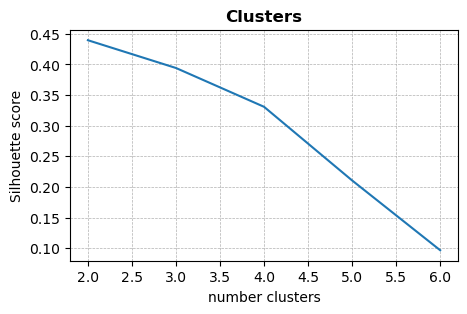

In [13]:
plt.figure(figsize=(5,3))
plt.plot(clusters,silhouttes)
plt.grid(True,lw=0.5,ls='--')
plt.ylabel('Silhouette score')
plt.xlabel('number clusters')
plt.title('Clusters',fontweight='bold');

In [14]:
model = AgglomerativeClustering(metric='precomputed',
                                n_clusters=2,
                                linkage='complete').fit(distance_matrix)
clusters = model.labels_
c = dict(zip(list_wh,clusters))
dc['clusters'] = dc['warehouse'].copy()
dc['clusters'] = dc['clusters'].map(c)
display(dc[['warehouse', 'clusters']].drop_duplicates().groupby('clusters').count().reset_index())
display(pd.DataFrame(list(c.items()), columns=['warehouse', 'cluster']).style.background_gradient(axis=0))

del dc
gc.collect()

,clusters,warehouse
0,0,5
1,1,2


,warehouse,cluster
0,Prague_1,1
1,Brno_1,1
2,Prague_2,0
3,Prague_3,0
4,Munich_1,0
5,Frankfurt_1,0
6,Budapest_1,0


3509

In [15]:
# Önce train veri seti için KMeans kullanımı
X_train = train[['orders']].values  # orders sütununu alarak X_train'i oluşturuyoruz

max_clusters = 6
clusters = np.arange(2, max_clusters + 1)
silhouettes_train = []

for c in clusters:
    kmeans = KMeans(n_clusters=c, random_state=42, n_init=10)  # n_init parametresini belirtiyoruz
    labels_train = kmeans.fit_predict(X_train)
    silhouette_avg_train = silhouette_score(X_train, labels_train)
    silhouettes_train.append(silhouette_avg_train)

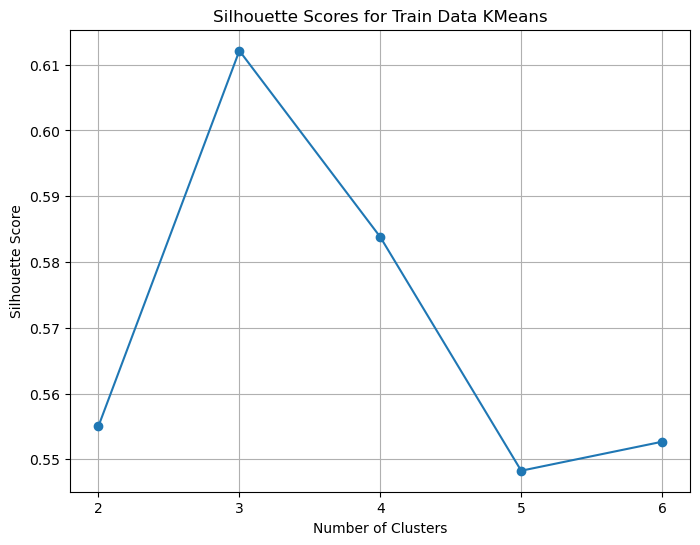

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(clusters, silhouettes_train, marker='o')
plt.title('Silhouette Scores for Train Data KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(clusters)
plt.grid(True)
plt.show()

In [17]:
# As we can see, from the results Prague_1 and Brno_1 belong to the same cluster, 
# and the others to another. We can train 2 models, one for each cluster.

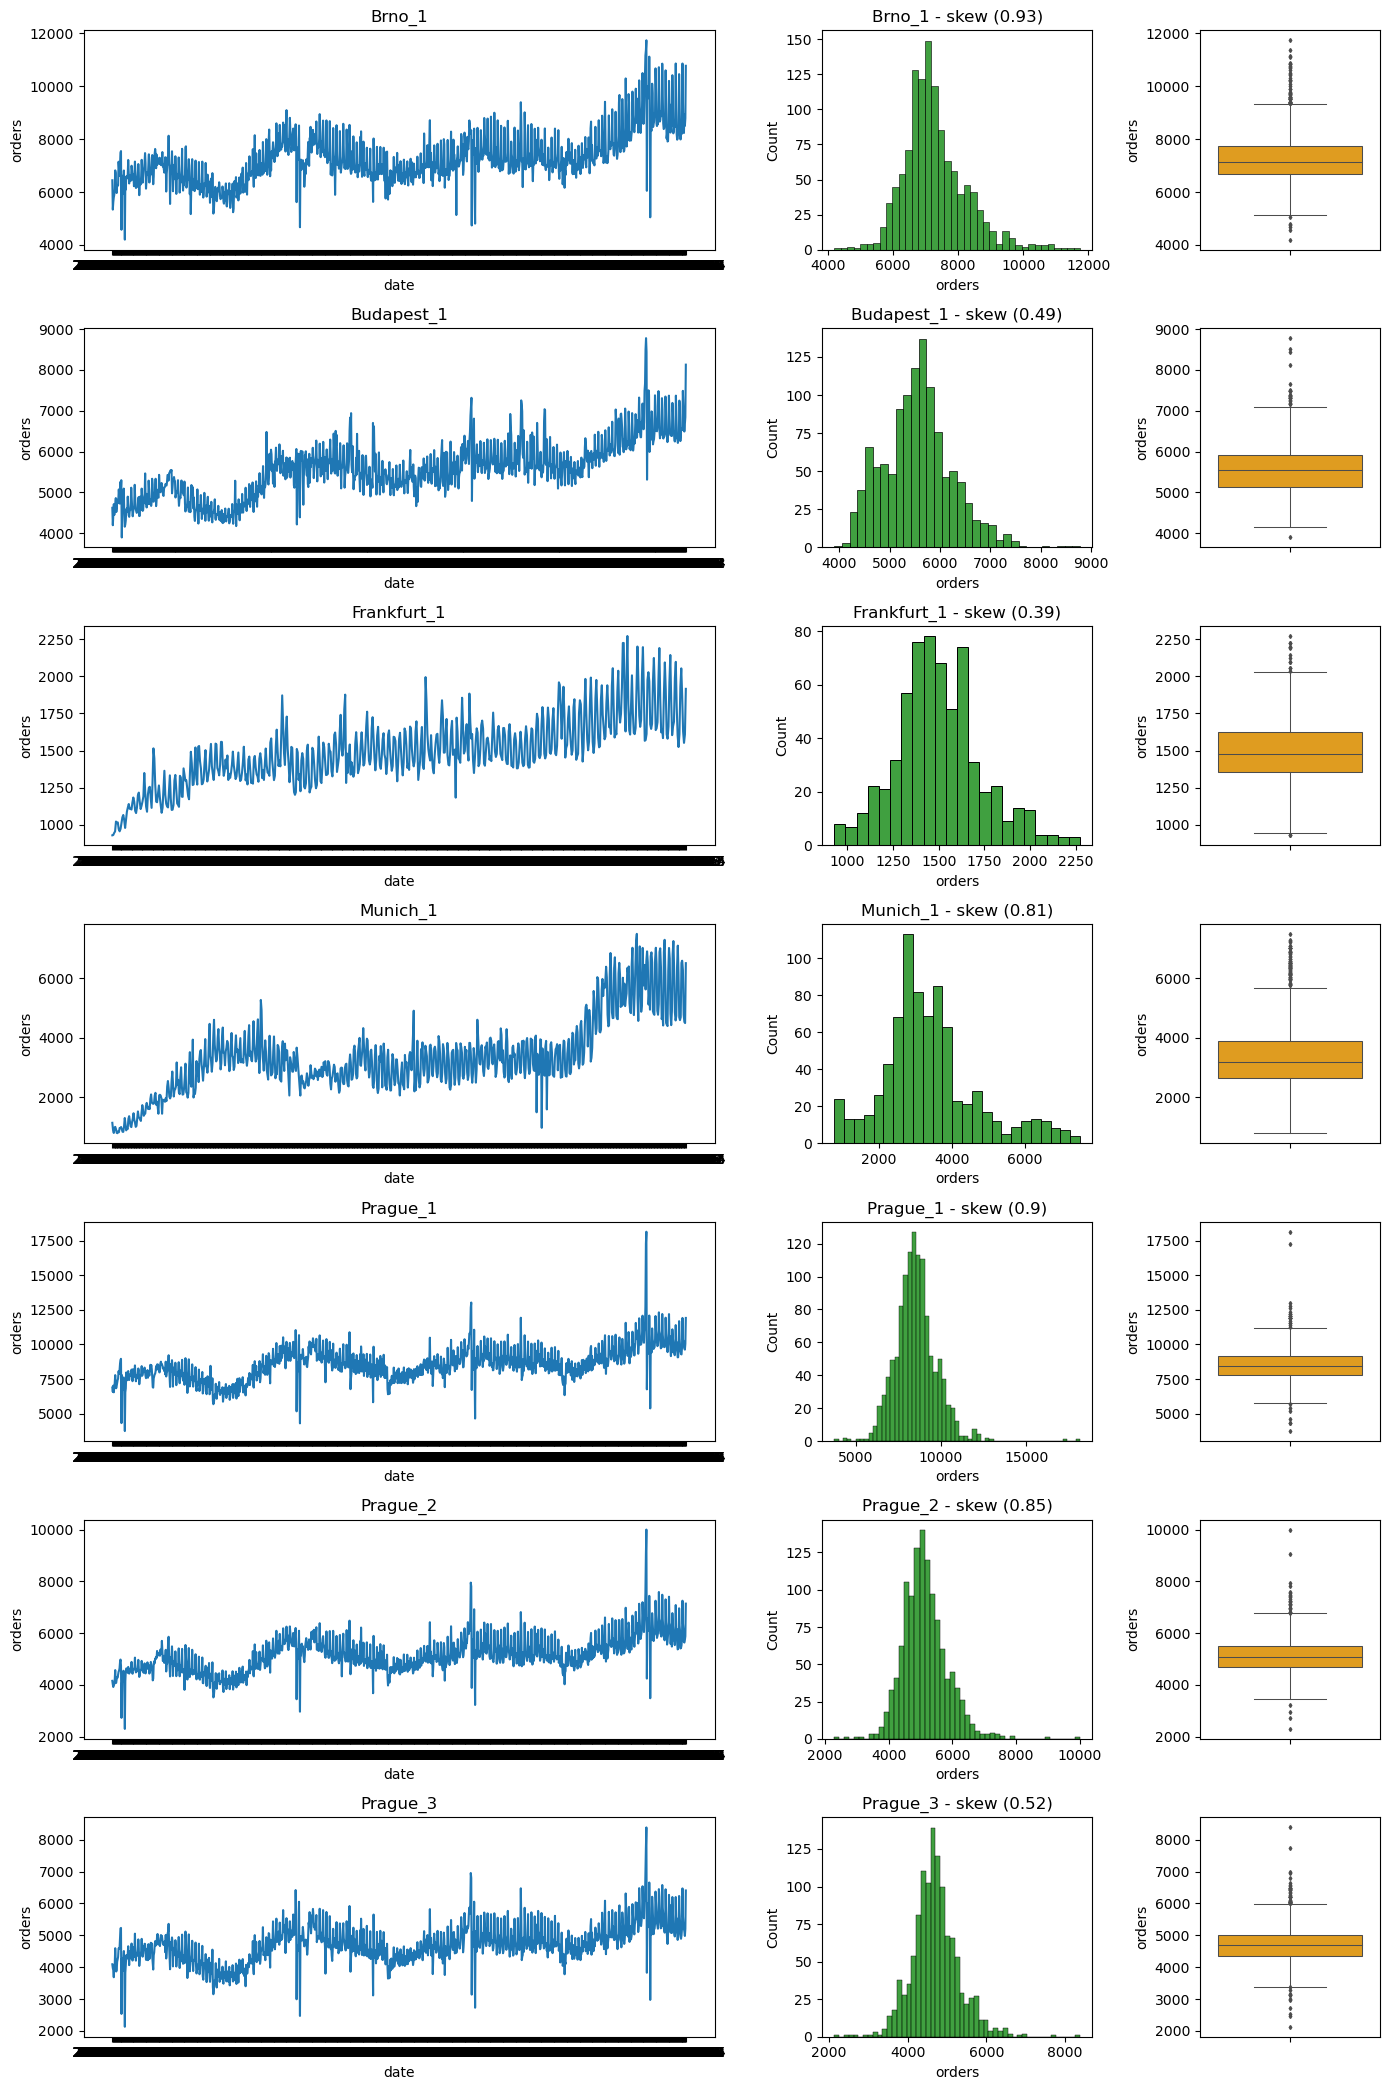

In [18]:
fig, axes = plt.subplots(7,3, figsize=(14,7*3), gridspec_kw={'width_ratios':[0.70, 0.30, 0.20 ]})

for i,(ind, c) in enumerate(train.groupby('warehouse')):   
    ax = axes[i,0]
    sns.lineplot(data=c,x=c.date,y='orders',ax=ax)
    ax.set_title(f'{ind}')
    
    ax = axes[i,1]
    sns.histplot(data=c,x='orders',ax=ax,color='green')               
    ax.set_title(f'{ind} - skew ({c.orders.skew().round(2)})')
    
    ax = axes[i,2]
    sns.boxplot(data=c,y='orders',ax=ax,color='orange', linewidth=.75, fliersize=2.01, width=0.80)               
    
plt.tight_layout()    

In [19]:
from sklearn.preprocessing import StandardScaler

# Numerik sütunların seçimi
numerik_sutunlar = ['orders', 'holiday', 'shutdown', 'mini_shutdown', 'shops_closed', 
                    'winter_school_holidays', 'school_holidays', 'blackout', 
                    'mov_change', 'frankfurt_shutdown', 'precipitation', 'snow', 
                    'user_activity_1', 'user_activity_2']

# Verilerin normalizasyonu
scaler = StandardScaler()
train_normalize = scaler.fit_transform(train[numerik_sutunlar])

train_normalize[:5]  # İlk 5 satırı göster


array([[ 0.62292621, -0.16736548, -0.01167298, -0.02335072, -0.10497278,
        -0.17578076, -0.08446903, -0.03089642, -0.53989206, -0.0165092 ,
        -0.34943258, -0.18405109,  0.11280783,  1.01832601],
       [ 0.48043114, -0.16736548, -0.01167298, -0.02335072, -0.10497278,
        -0.17578076, -0.08446903, -0.03089642, -0.53989206, -0.0165092 ,
        -0.34943258, -0.18405109,  0.0694468 ,  1.01071485],
       [ 0.68478098, -0.16736548, -0.01167298, -0.02335072, -0.10497278,
        -0.17578076, -0.08446903, -0.03089642, -0.53989206, -0.0165092 ,
        -0.34943258, -0.18405109,  0.0796494 ,  1.01575165],
       [ 0.4648529 , -0.16736548, -0.01167298, -0.02335072, -0.10497278,
        -0.17578076, -0.08446903, -0.03089642, -0.53989206, -0.0165092 ,
        -0.17040774, -0.18405109,  0.06051953,  1.00131281],
       [ 0.62979896, -0.16736548, -0.01167298, -0.02335072, -0.10497278,
        -0.17578076, -0.08446903, -0.03089642, -0.53989206, -0.0165092 ,
        -0.23754206, -0.18

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

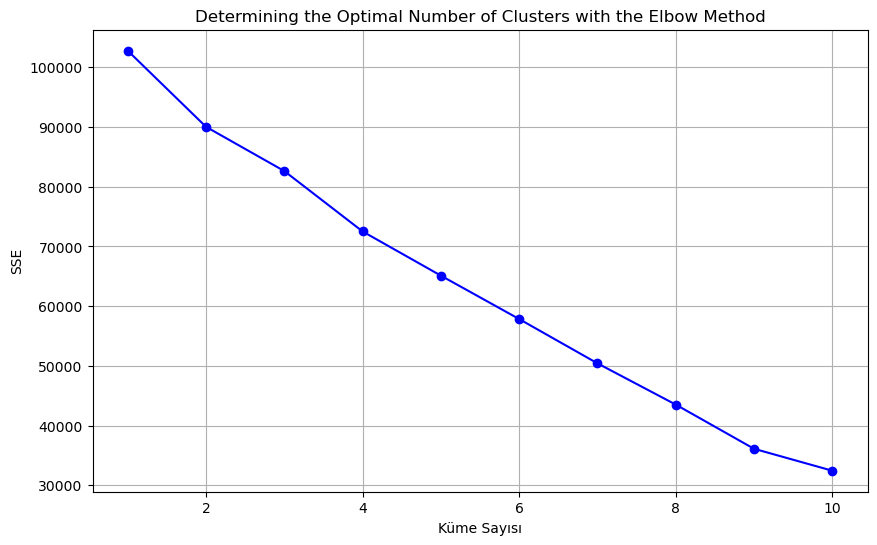

In [27]:
sse = []
kume_sayilari = range(1, 11)
for k in kume_sayilari:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_normalize)
    sse.append(kmeans.inertia_)

# SSE grafiği
plt.figure(figsize=(10, 6))
plt.plot(kume_sayilari, sse, 'bo-')
plt.xlabel('Küme Sayısı')
plt.ylabel('SSE')
plt.title('Determining the Optimal Number of Clusters with the Elbow Method')
plt.grid(True)
plt.show()

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

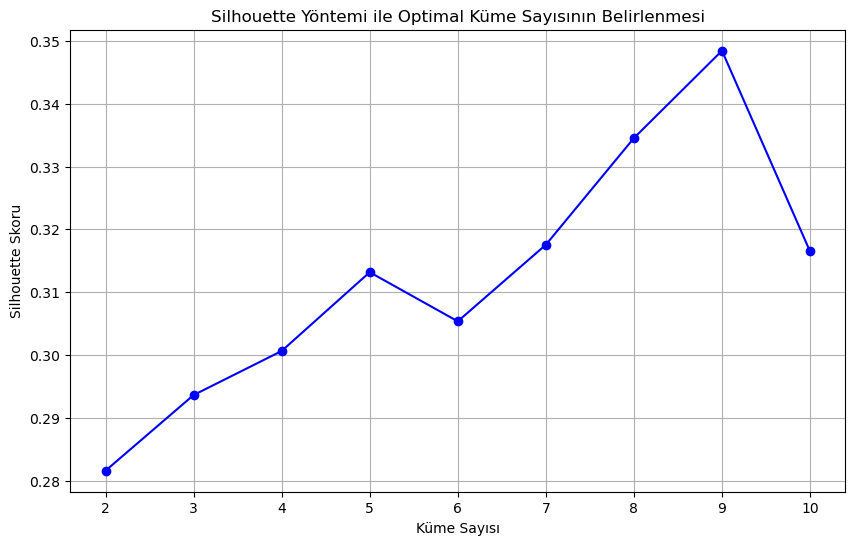

In [21]:
# Silhouette skoru hesaplama
silhouette_scores = []
kume_sayilari = range(2, 11)
for k in kume_sayilari:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_normalize)
    score = silhouette_score(train_normalize, kmeans.labels_)
    silhouette_scores.append(score)

# Silhouette skoru grafiği
plt.figure(figsize=(10, 6))
plt.plot(kume_sayilari, silhouette_scores, 'bo-')
plt.xlabel('Küme Sayısı')
plt.ylabel('Silhouette Skoru')
plt.title('Silhouette Yöntemi ile Optimal Küme Sayısının Belirlenmesi')
plt.grid(True)
plt.show()

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


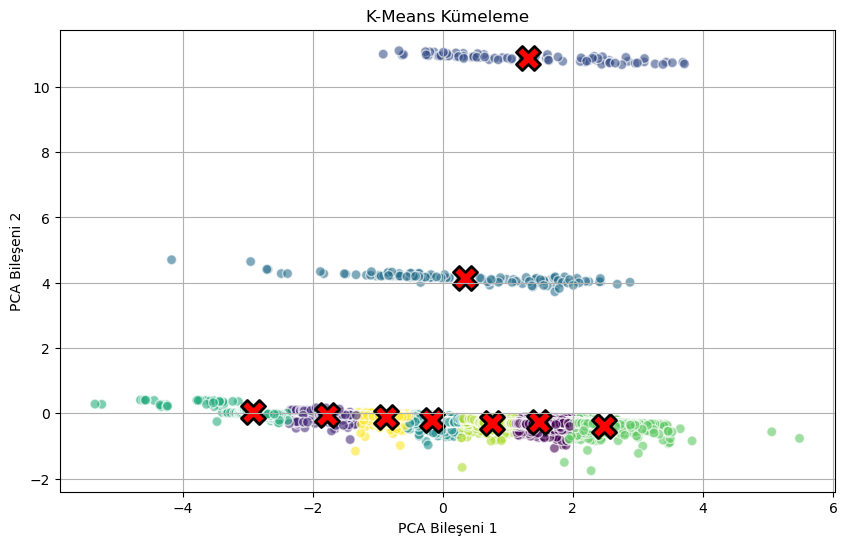

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt

# Numerik sütunların seçimi
numerik_sutunlar = ['orders', 'holiday', 'shutdown', 'mini_shutdown', 'shops_closed', 
                    'winter_school_holidays', 'school_holidays', 'blackout', 
                    'mov_change', 'frankfurt_shutdown', 'precipitation', 'snow', 
                    'user_activity_1', 'user_activity_2']

# Verilerin normalizasyonu
scaler = StandardScaler()
train_normalize = scaler.fit_transform(train[numerik_sutunlar])

# PCA ile boyut indirgeme (ilk 2 bileşen)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(train_normalize)

# K-Means uygulama
kmeans = KMeans(n_clusters=9, random_state=42)
kmeans.fit(pca_data)
kume_etiketleri = kmeans.labels_

# Küme merkezlerini görselleştirme
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kume_etiketleri, cmap='viridis', s=50, alpha=0.6, edgecolors='w')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', edgecolors='black', linewidth=2)
plt.title("K-Means Kümeleme")
plt.xlabel('PCA Bileşeni 1')
plt.ylabel('PCA Bileşeni 2')
plt.grid(True)
plt.show()


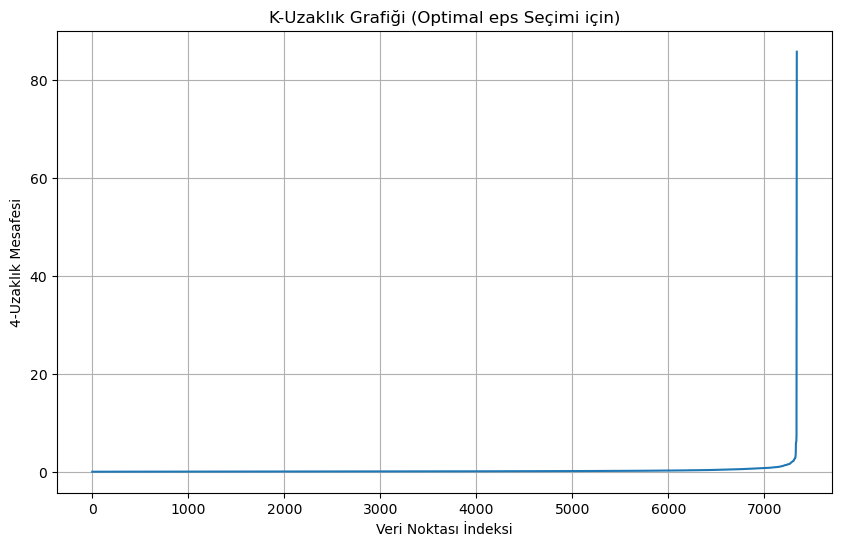

In [23]:
# K-nearest neighbors modeli
from sklearn.neighbors import NearestNeighbors
k = 4  # min_samples = 4 için
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(train_normalize)
distances, indices = neighbors_fit.kneighbors(train_normalize)

# K-uzaklık grafiği
distances = np.sort(distances[:, k-1], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Veri Noktası İndeksi')
plt.ylabel(f'{k}-Uzaklık Mesafesi')
plt.title('K-Uzaklık Grafiği (Optimal eps Seçimi için)')
plt.grid(True)
plt.show()

In [24]:
# Silhouette skoru hesaplama
best_score = -1
best_eps = None
best_min_samples = None
for eps in np.arange(0.1, 1.5, 0.1):
    for min_samples in range(2, 10):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(train_normalize)
        if len(set(labels)) > 1:
            score = silhouette_score(train_normalize, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f'En İyi Silhouette Skoru: {best_score}')
print(f'Optimal eps: {best_eps}')
print(f'Optimal min_samples: {best_min_samples}')

En İyi Silhouette Skoru: 0.30764563073574147
Optimal eps: 0.5
Optimal min_samples: 8


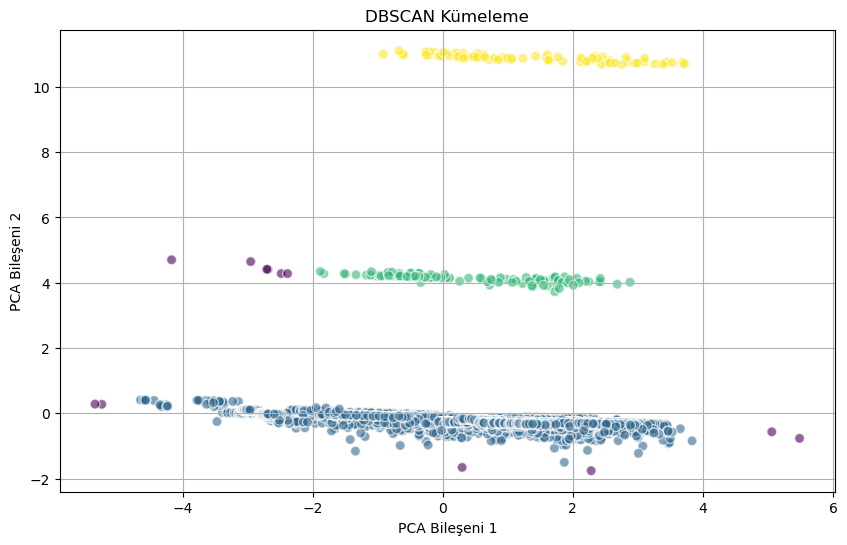

In [32]:
# DBSCAN uygulama
dbscan = DBSCAN(eps=0.5, min_samples=8)
dbscan.fit(pca_data)
dbscan_kume_etiketleri = dbscan.labels_

# Küme sonuçlarını görselleştirme
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=dbscan_kume_etiketleri, cmap='viridis', s=50, alpha=0.6, edgecolors='w')
plt.title("DBSCAN Kümeleme")
plt.xlabel('PCA Bileşeni 1')
plt.ylabel('PCA Bileşeni 2')
plt.grid(True)
plt.show()


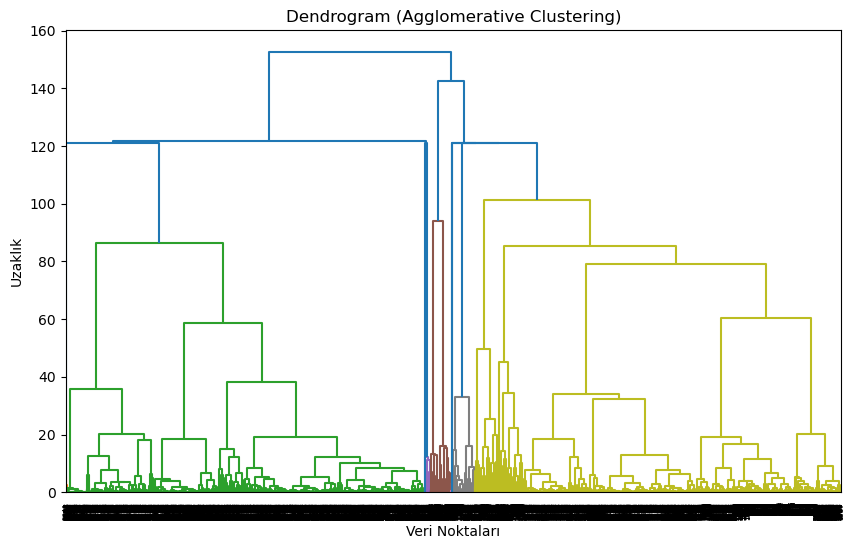

In [35]:
# Hiyerarşik kümeleme ve dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(train_normalize, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title('Dendrogram (Agglomerative Clustering)')
plt.xlabel('Veri Noktaları')
plt.ylabel('Uzaklık')
plt.show()

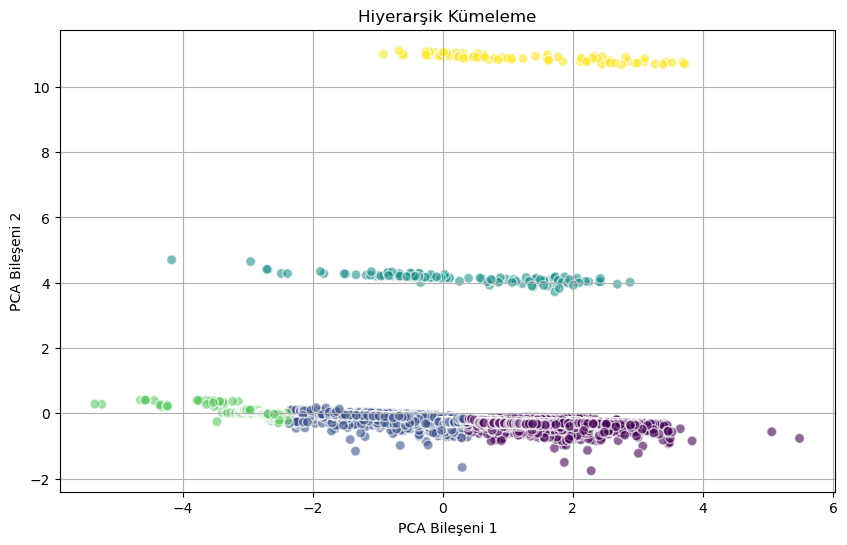

In [36]:
# Agglomerative Clustering uygulama
agg_clustering = AgglomerativeClustering(n_clusters=5)
agg_clustering.fit(pca_data)
agg_kume_etiketleri = agg_clustering.labels_

# Küme sonuçlarını görselleştirme
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=agg_kume_etiketleri, cmap='viridis', s=50, alpha=0.6, edgecolors='w')
plt.title("Hiyerarşik Kümeleme")
plt.xlabel('PCA Bileşeni 1')
plt.ylabel('PCA Bileşeni 2')
plt.grid(True)
plt.show()


C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


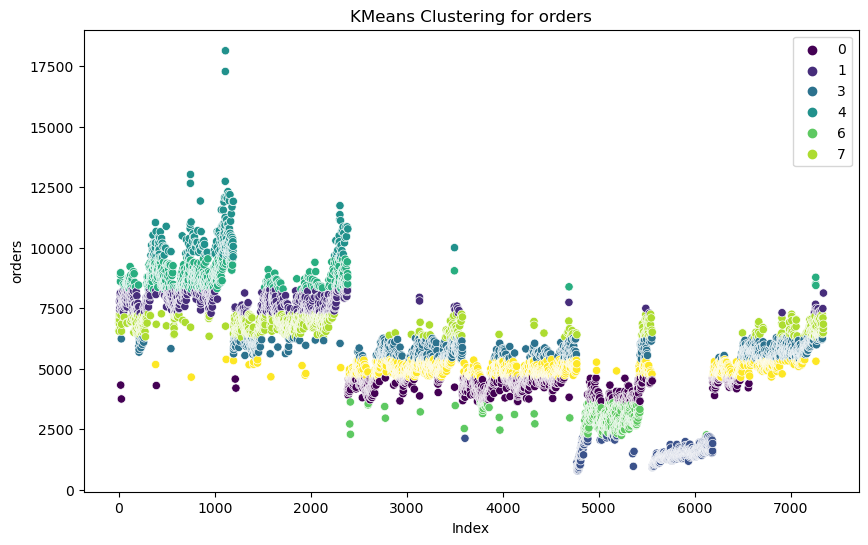

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alper\anaconda3\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


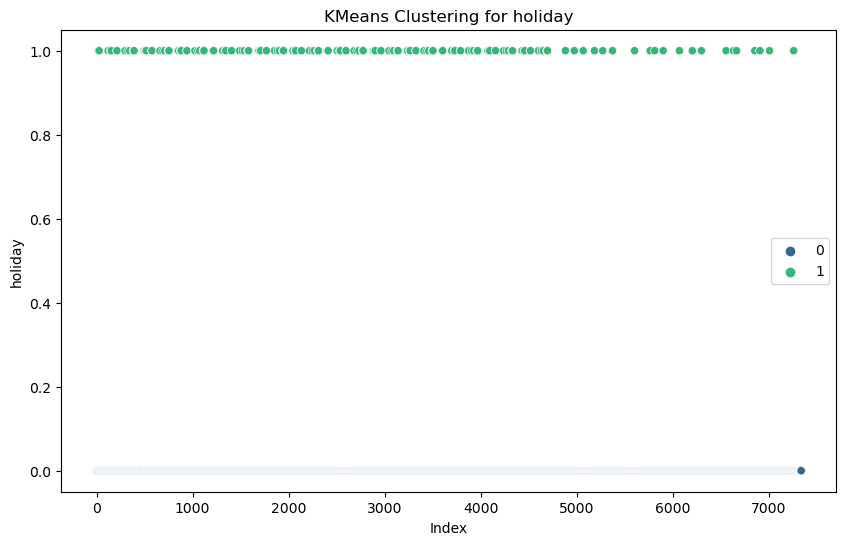

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alper\anaconda3\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


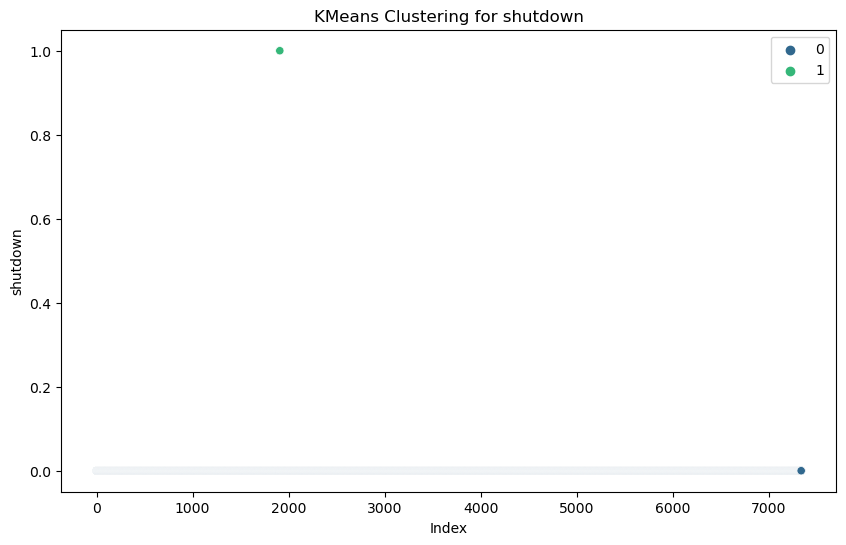

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alper\anaconda3\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


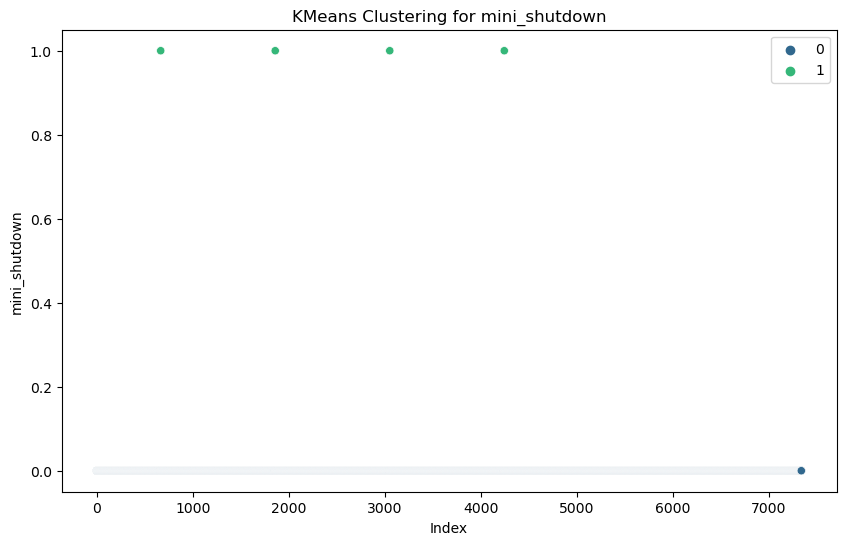

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alper\anaconda3\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


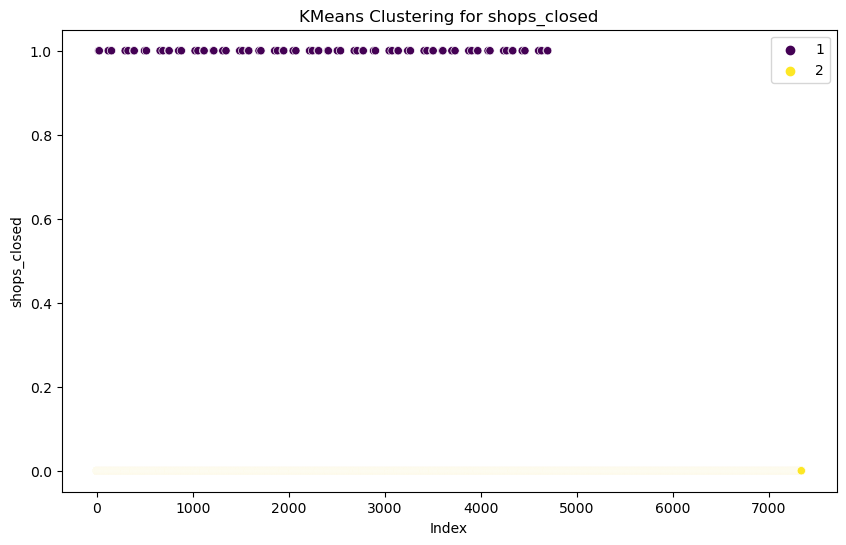

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alper\anaconda3\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


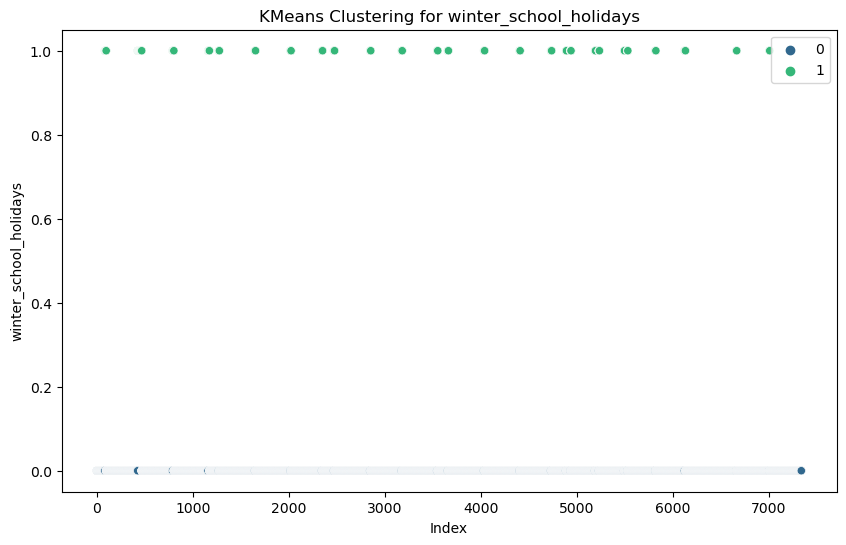

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alper\anaconda3\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


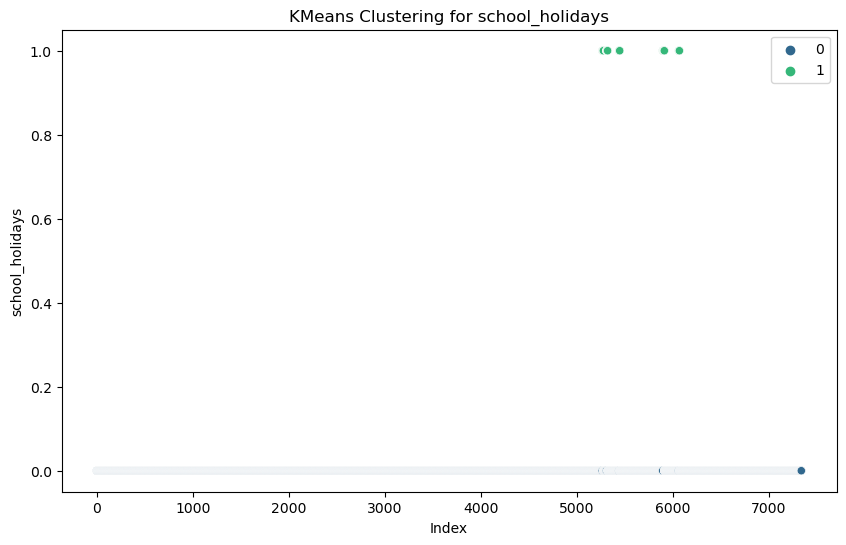

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alper\anaconda3\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


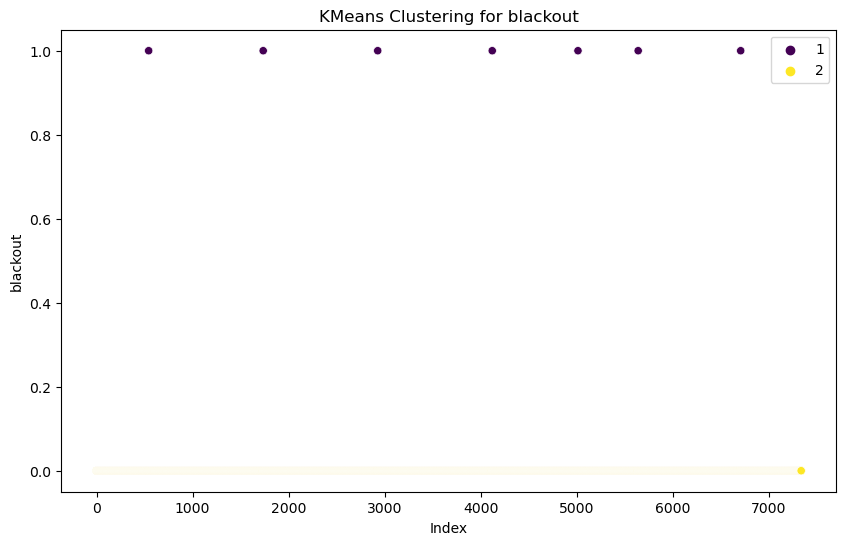

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alper\anaconda3\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


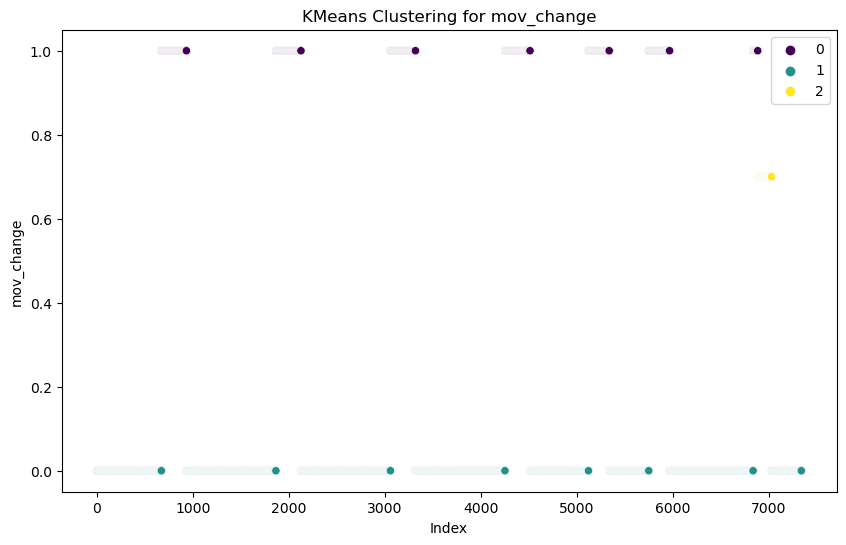

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alper\anaconda3\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


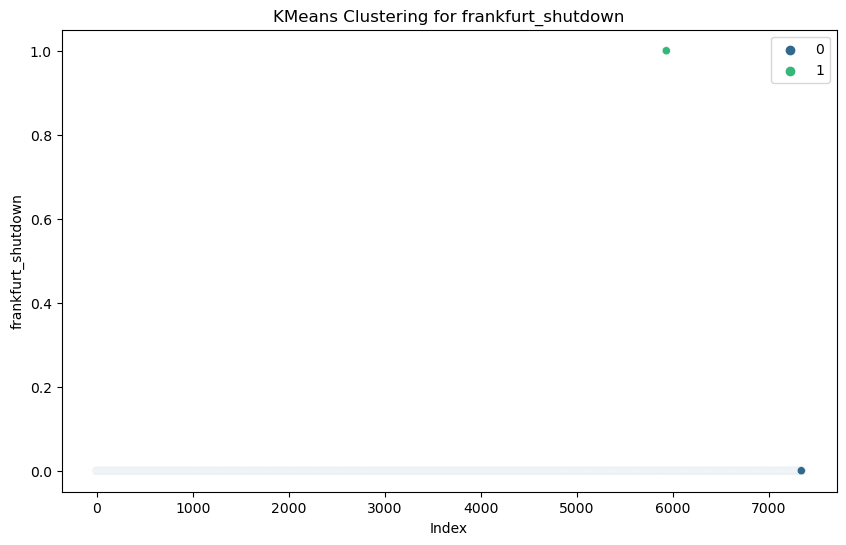

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


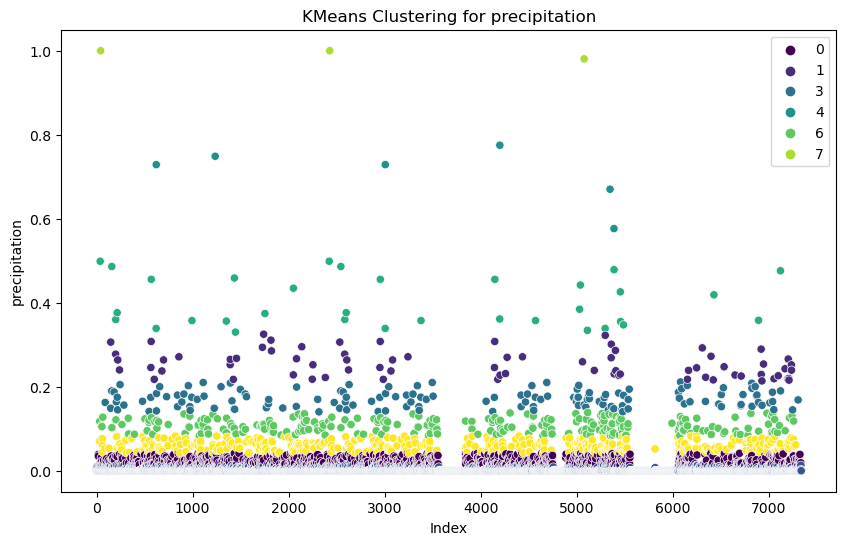

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


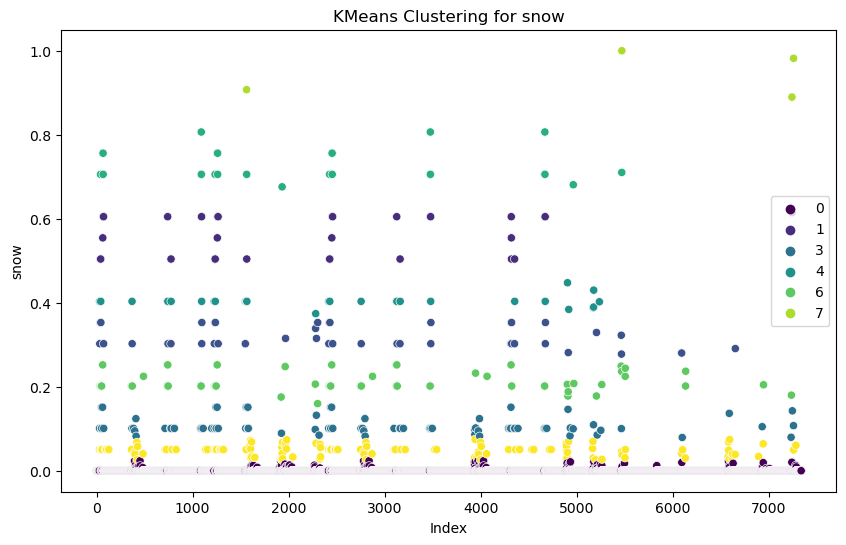

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


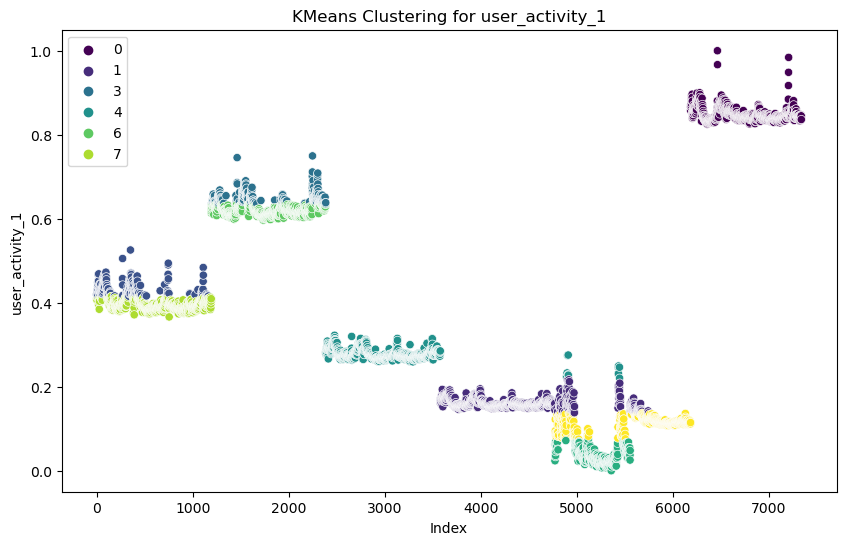

C:\Users\alper\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


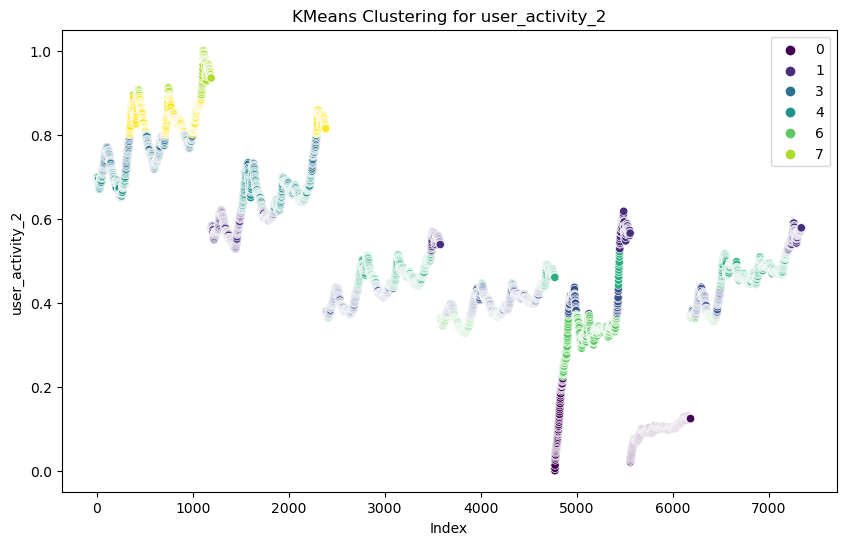

In [42]:
for column in numerik_sutunlar:
    # KMeans Clustering
    kmeans = KMeans(n_clusters=9)
    clusters = kmeans.fit_predict(train[[column]])
    
    # Sonuçların görselleştirilmesi
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=range(len(train)), y=train[column], hue=clusters, palette='viridis')
    plt.title(f'KMeans Clustering for {column}')
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.show()


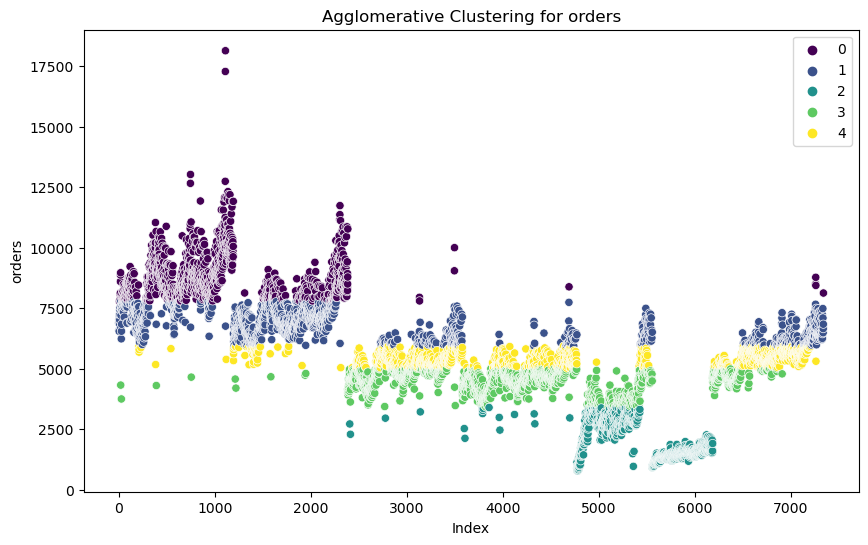

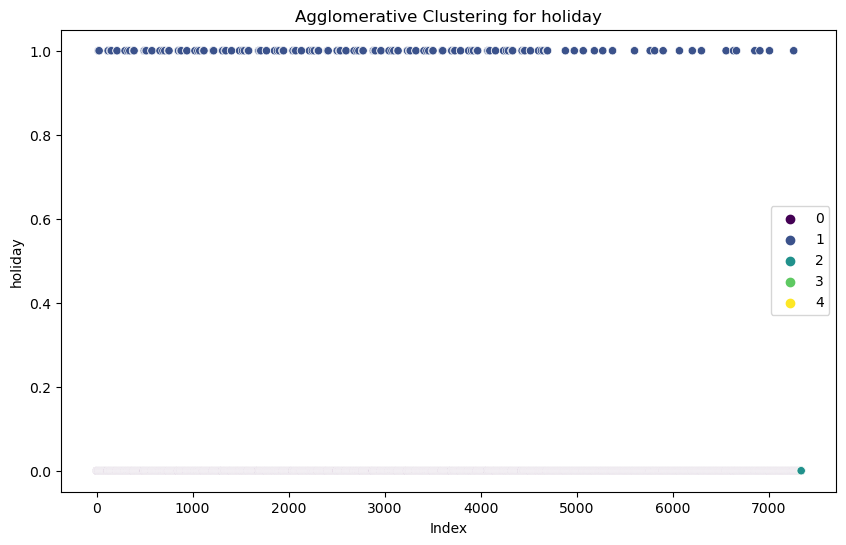

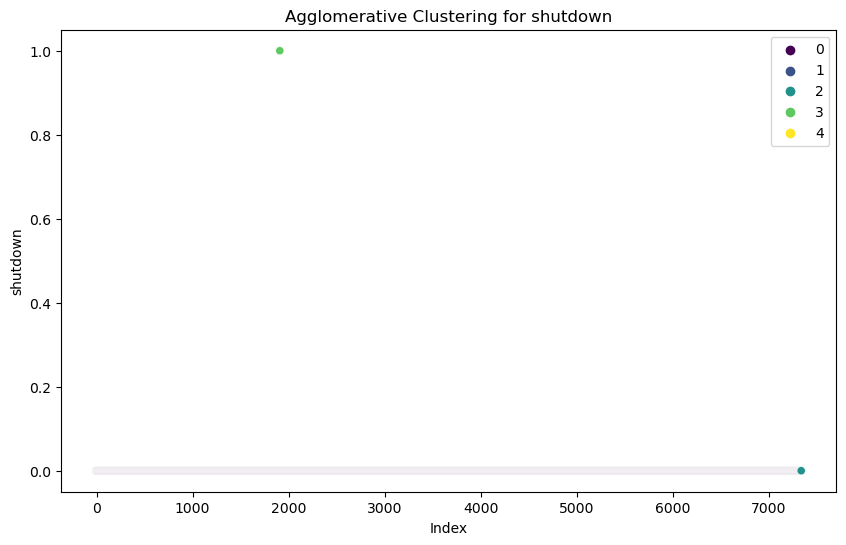

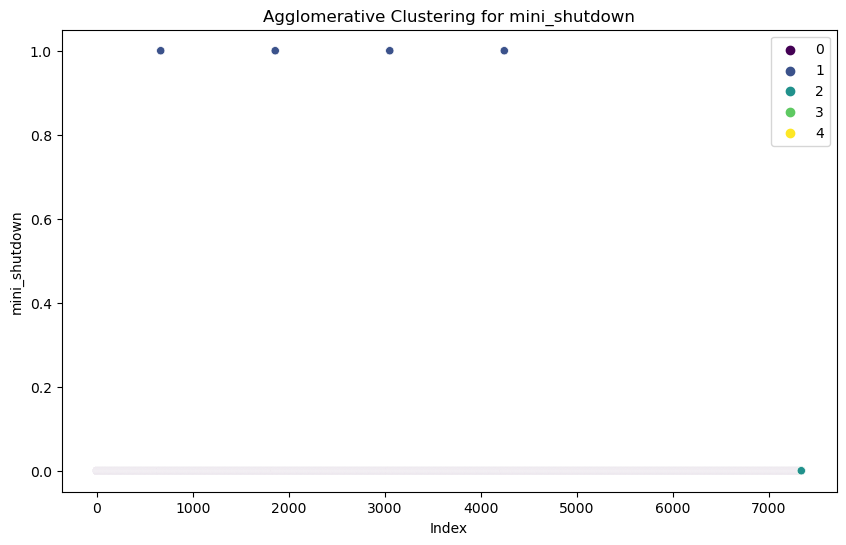

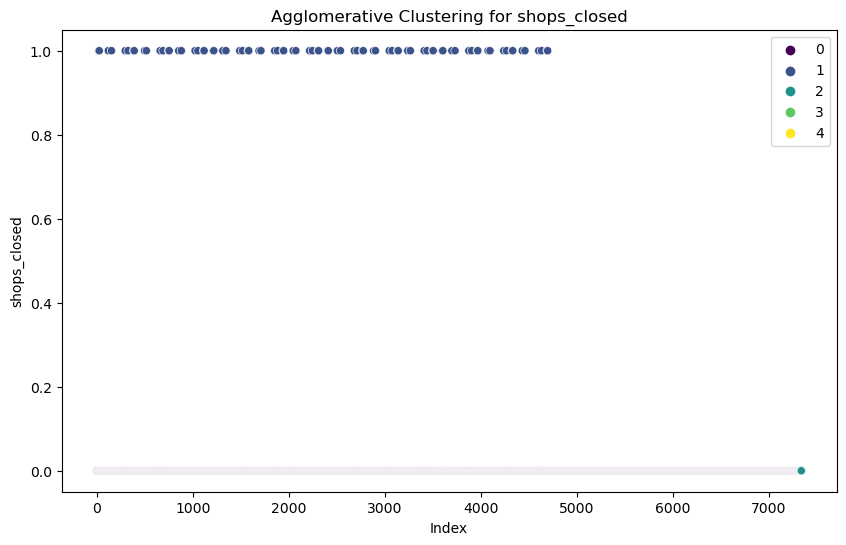

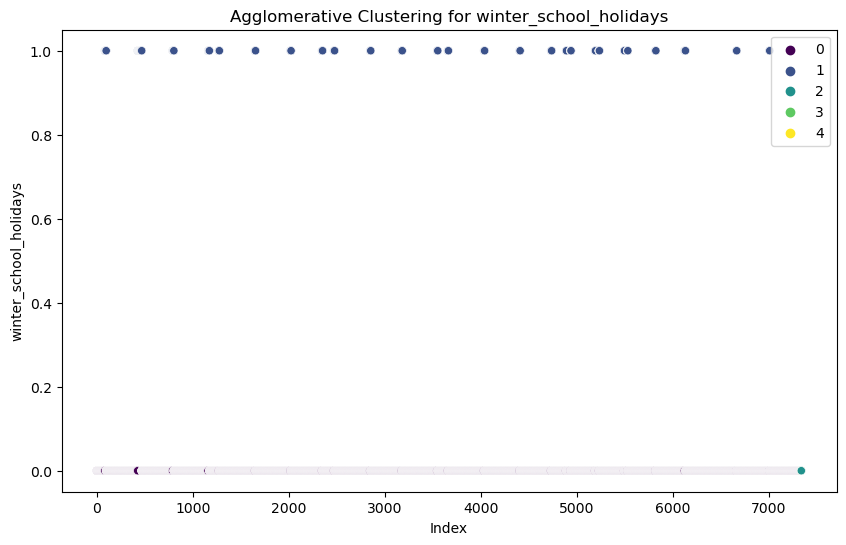

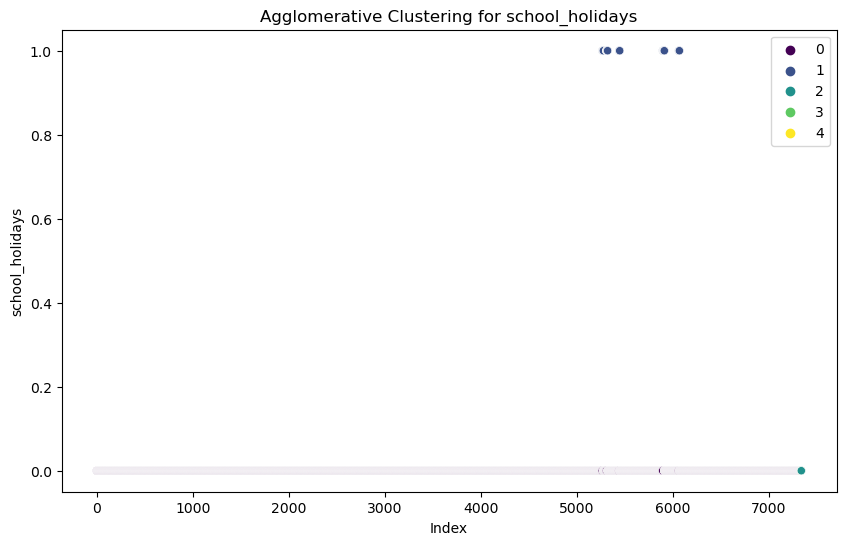

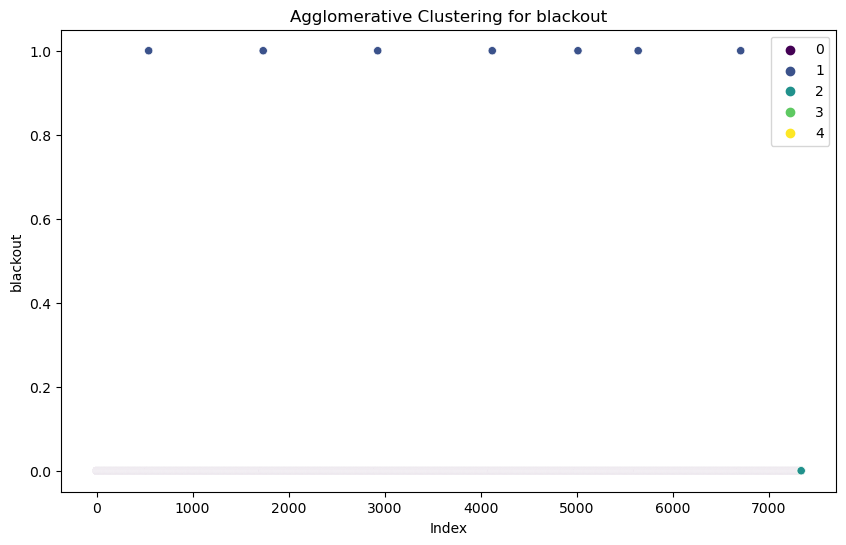

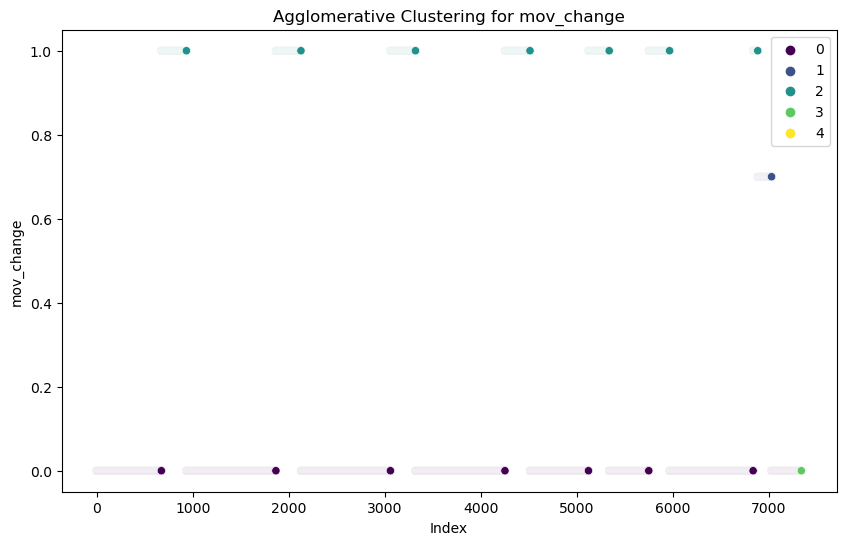

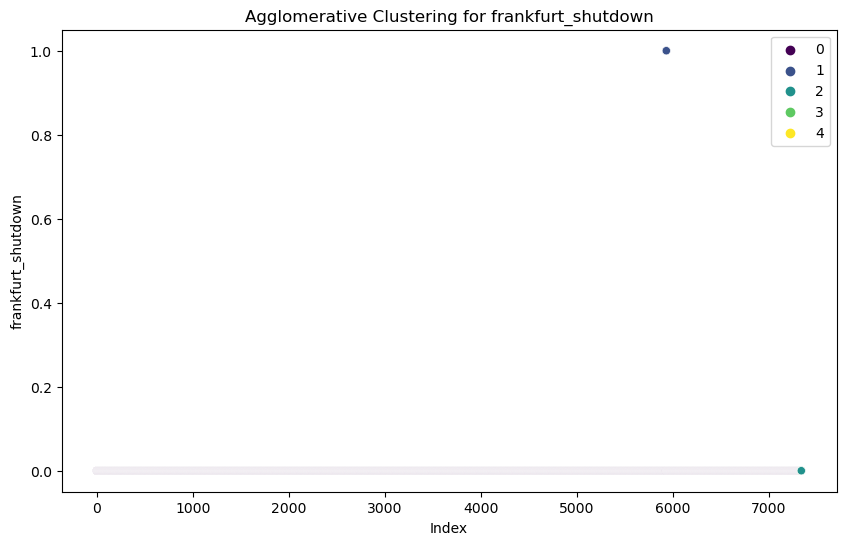

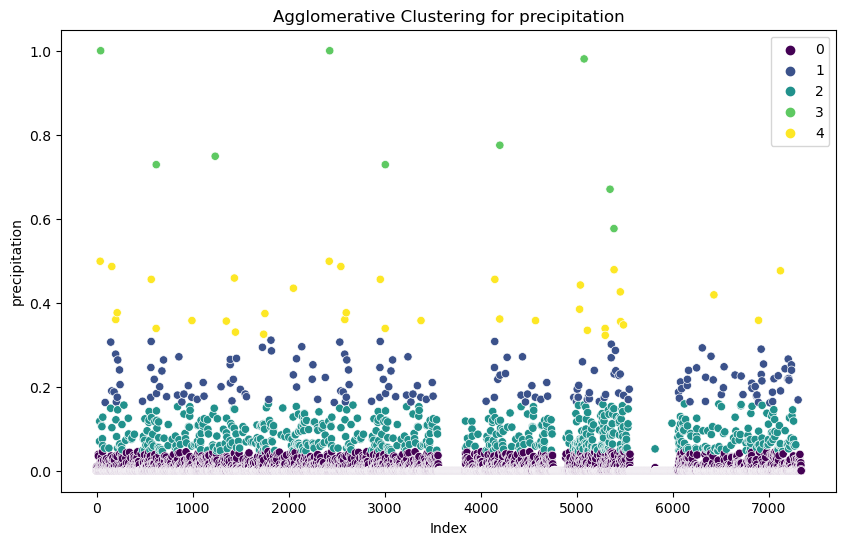

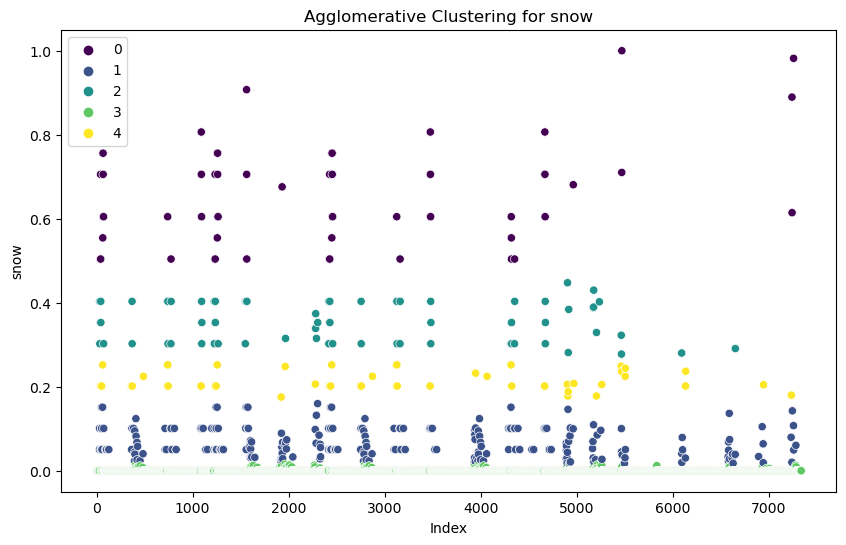

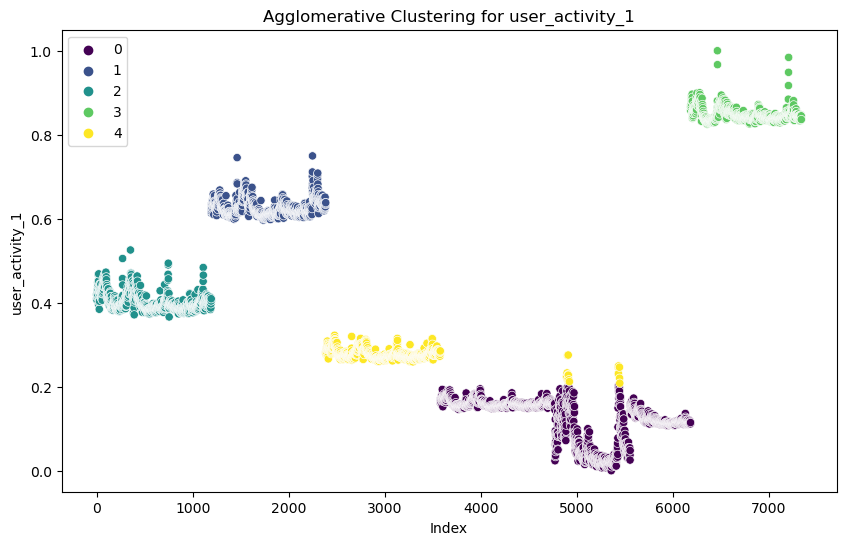

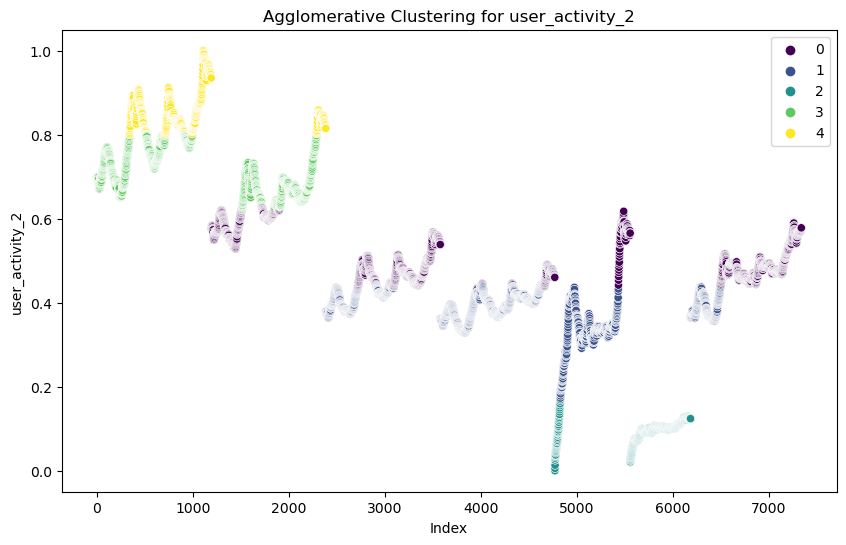

In [43]:
for column in numerik_sutunlar:
    # Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=5)
    clusters = agglomerative.fit_predict(train[[column]])
    
    # Sonuçların görselleştirilmesi
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=range(len(train)), y=train[column], hue=clusters, palette='viridis')
    plt.title(f'Agglomerative Clustering for {column}')
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.show()
